In [7]:
import numpy as np
from enum import IntEnum
from copy import deepcopy
import matplotlib.pyplot as plt
# plt.style.use('seaborn-notebook')
# plt.style.use('seaborn-whitegrid')
import matplotlib.colors as mcolors

np.random.seed(0)

In [8]:
class Action(IntEnum):
    up = 0
    right = 1
    down = 2
    left = 3

action_to_str = {
    Action.up : "up",
    Action.right : "right",
    Action.down : "down",
    Action.left : "left",
}

action_to_offset = {
    Action.up : (-1, 0),
    Action.right : (0, 1),
    Action.down : (1, 0),
    Action.left : (0, -1),
}

In [9]:
class GridWorld:

    def __init__(self, height, width, goal, goal_value=1, danger=[], danger_value=-1, blocked=[], noise=0.0):
        """
        Initialize the GridWorld environment.
        Creates a gridworld like MDP
         - height (int): Number of rows
         - width (int): Number of columns
         - goal (int): Index number of goal cell
         - goal_value (float): Reward given for goal cell
         - danger (list of int): Indices of cells marked as danger
         - danger_value (float): Reward given for danger cell
         - blocked (list of int): Indices of cells marked as blocked (can't enter)
         - noise (float): probability of resulting state not being what was expected
        """

        self._width = width
        self._height = height
        self._grid_values = [0 for _ in range(height * width)] # Initialize state values.
        self._goal_value = goal_value
        self._danger_value = danger_value
        self._goal_cell = goal
        self._danger_cells = danger
        self._blocked_cells = blocked
        self._noise = noise # Noise level in the environment.
        assert noise >= 0 and noise < 1 # Ensure valid noise value.
        self._state_indexes = self.get_state_from_index()

    def reset(self):
        """
        Reset the state values to their initial state.
        """
        self._grid_values = [0 for _ in range(self._height * self._width)]

    def get_index_state(self, state):
        """
        Get the index of the state in the grid
        """
        return state[0] * self._width + state[1]

    def get_state_from_index(self):

      state_indexes = {}
      counter = 0
      for i in range(self._height):
        for j in range(self._width):
          state_indexes[counter] = (i, j)
          counter+=1

      return state_indexes

    def _state_reward_from_action(self, state, action):
        """
        Gets the state as a result of applying the given action
        """

        random_noise = np.random.rand()
        actions_list = list(action_to_str.keys())
        action_base = action

        # adding noise to the model, choose random actions with probability < noise
        if random_noise < self._noise:
            action = np.random.choice(actions_list)

        is_action_same = action == action_base
        # get the next state based on the actions table
        next_state_r, next_state_c = (state[0] + action_to_offset[action][0]), (state[1] + action_to_offset[action][1])

        # if the actions leads to out of bounds states then we keep the state we have
        if next_state_r < 0 or next_state_r >= self._height:
            next_state_r = state[0]
        if next_state_c < 0 or next_state_c >= self._width:
            next_state_c = state[1]

        next_state = next_state_r, next_state_c
        # get the index of the next state in the grid to be consistent with the test cases
        next_state_index = self.get_index_state(next_state)

        # if the next state is a blocke cell then next state will still be the current state
        if next_state_index in self._blocked_cells:
            next_state = state
            next_state_index = self.get_index_state(next_state)

        return next_state_index, self.get_reward(next_state_index)

    def is_terminal(self, state):
        """
        Returns true if a state is terminal (goal, or danger)
        """
        return (state == self._goal_cell) or (state in self._danger_cells)

    def get_reward(self, state):
        """
        Get the reward for being in the current state
        """
        if state == self._goal_cell:
            return self._goal_value
        elif state in self._danger_cells:
            return self._danger_value
        else:
            return -0.1

    def __str__(self):
        """
        Pretty print the state values
        """
        out_str = ""
        for r in range(self._height):
            for c in range(self._width):
                cell = r * self._width + c
                if cell in self._blocked_cells:
                    out_str += "{:>6}".format("----")
                elif cell == self._goal_cell:
                    out_str += "{:>6}".format("GOAL")
                elif cell in self._danger_cells:
                    out_str += "{:>6}".format("-1.00")
                else:
                    out_str += "{:>6.2f}".format(self._grid_values[cell])
                out_str += " "
            out_str += "\n"
        print(out_str)
        return out_str

In [10]:
# Initialize your GridWorld
grid = GridWorld(height=3, width=4, goal=3, danger=[7], blocked=[5], noise=0.0)

In [11]:
simple_gw = grid
simple_gw.__str__()

  0.00   0.00   0.00   GOAL 
  0.00   ----   0.00  -1.00 
  0.00   0.00   0.00   0.00 



'  0.00   0.00   0.00   GOAL \n  0.00   ----   0.00  -1.00 \n  0.00   0.00   0.00   0.00 \n'

In [12]:
import math
from collections import defaultdict
from tqdm.notebook import tqdm

In [13]:
static_states_indexes = grid._blocked_cells + grid._danger_cells + [grid._goal_cell]

# states that can be start state
start_states_indexes = [x for x in range(grid._height * grid._width) if x not in static_states_indexes]

start_states_indexes

[0, 1, 2, 4, 6, 8, 9, 10, 11]

In [14]:
# I will be using action-value function instead of state value function to make it model-free
def gen_episode(grid, n_iterations = 30, is_exploring = False, is_control = False, q_table = None, epsilon = 0):
    """
    this function generates one episodes that tesminates when it reaches the goal or if it has 30 iterations
    """

    # static states in my environment are blocked and danger or goal cells, those are cells that you can't start from
    static_states_indexes = grid._blocked_cells + grid._danger_cells + [grid._goal_cell]

    # states that can be start state
    start_states_indexes = [x for x in range(grid._height * grid._width) if x not in static_states_indexes]
    actions_list = list(action_to_str.keys())

    episode = []

    # if exploring starts problem then we pick one of the starting states at random
    if is_exploring:
        init_state = grid._state_indexes[np.random.choice(start_states_indexes)]
    else:
    # if not exploring starts then we start at cell 8 as required in the description
        init_state = (2, 0)

    # states are tuples in my environment so I calculate their index below
    state = init_state
    state_index = grid.get_index_state(state)

    iter = 0
    is_winning = False

    # the episode is done if we step into a terminal or if the number of steps exceeds 30
    while iter <= n_iterations:

        # if this function is called from control problem then we select action with epsilon greedy policy
        # so we calculate the epsilon probabilitied of the avtions in a state to balance between exploration and
        # exploitation for MC control epsilon greedy policy
        if ((iter == 0) and is_exploring):

          action = np.random.choice(actions_list)

        else:
          if is_control:
            if state_index in q_table:
              # probability of acting greedy is 1 - epsilon * epsilon / n
              # probability of chosing and arbitrary action (exploration) is epsilon / n
              state_proba = (epsilon / len(actions_list)) * np.ones(len(actions_list))
              best_state_action = np.argmax(q_table[state_index])
              state_proba[best_state_action] = (1 - epsilon) + (epsilon / len(actions_list))

              action = np.random.choice(actions_list, p=state_proba)

            else:
              # if the state is a non-visited state before then we choose random policy
              action = np.random.choice(actions_list)
          else:
            # if we are solving prediction not control then we choose a random policy
            action = np.random.choice(actions_list)

        # now we get the next state and reward for the current state and repeat to have a full episode
        next_state_index, reward = grid._state_reward_from_action(state, action)
        episode.append((state, action, reward))
        state = grid._state_indexes[next_state_index]
        state_index = grid.get_index_state(state)

        # if the state is a terminal state then we terminate the episode
        if grid.is_terminal(state_index):
          is_winning = state_index == grid._goal_cell
          break

        iter += 1

    return episode, is_winning



def get_q_table_mc_pred(env, num_episodes, discount_rate=1, is_exploring = False):

    n_actions = len(list(action_to_str.keys()))
    n_state_action_visits = defaultdict(lambda: np.zeros(n_actions))
    q_table = defaultdict(lambda: np.zeros(n_actions))
    rewards_sum = defaultdict(list)


    for ep in tqdm(range(num_episodes)):

        episode, succeeded = gen_episode(env, 30, is_exploring)
        states, actions, rewards = zip(*episode)
        states_indexes = [env.get_index_state(state) for state in states]

        # number of states which is the same number of discount values, where
        # at each step we make exponent of gamma ** t as the discount factor
        len_disc = len(states_indexes)

        accumulated_discounted_reward = 0
        for i in range(len_disc - 1,  -1, -1):

            state = states_indexes[i]
            # getting the sum of the discounted rewards for this state action pair
            accumulated_discounted_reward = accumulated_discounted_reward * discount_rate + rewards[i]

            # calculating the accumulated sum of this state action pair over all episodes
            rewards_sum[state, actions[i]].append(accumulated_discounted_reward)

            # updating the counter of the number of visits for this state action pair over all episodes
            n_state_action_visits[state][actions[i]] += 1.0

            # update the state_action (Q) table using the latest average of the returns of this state over all previous and current episode
            q_table[state][actions[i]] = np.mean(rewards_sum[state, actions[i]])

    return q_table

In [15]:
q_table = get_q_table_mc_pred(grid, 1000, is_exploring = True)

sorted(q_table.items())

  0%|          | 0/1000 [00:00<?, ?it/s]

[(0, array([-1.27431973, -1.0544702 , -1.50753769, -1.39383562])),
 (1, array([-1.12293987, -0.53558648, -1.0837963 , -1.40798319])),
 (2, array([-0.56235294,  1.        , -0.97668919, -1.14086022])),
 (4, array([-1.31490015, -1.57885463, -1.71459293, -1.56069869])),
 (6, array([-0.414     , -1.        , -1.46178862, -1.06113744])),
 (8, array([-1.65349922, -1.62608696, -1.72425249, -1.70434084])),
 (9, array([-1.70427509, -1.45214844, -1.64109848, -1.74896811])),
 (10, array([-1.09403794, -1.43666667, -1.57344173, -1.7619186 ])),
 (11, array([-1.        , -1.48941176, -1.5023622 , -1.52192982]))]

From the book https://rdcu.be/dLCM2



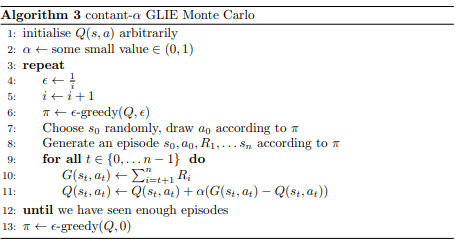

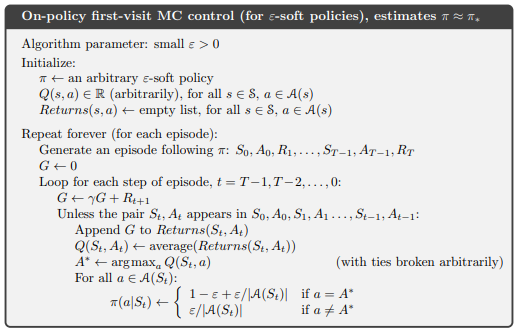

In [22]:
def control_const_alpha(env, num_episodes, alpha = 0.02, discount_rate=1.0, epsilon=0.15, glie_update  = False, is_exploring = False, verbose = True):
    n_actions = len(list(action_to_str.keys()))
    q_table = defaultdict(lambda: np.zeros(n_actions))

    # we append to a list of the state action pair the rerturn from each episode
    # this is used if we are not using the GLIE variant with incremintal alpha update of the mean
    # where glie stands for Greedy in the limit of infit exploration
    state_action_return_list = defaultdict(list)

    # for each episode we update the q_table with the averaged returns for each state
    # in the algorithm it doesn't say how averaging is done so I decided to do incremintal averaging
    # and instead of using the 1/N(S,A) I decided to use constant alpha to follow the constant-alpha GLIE epsilon greedy algorithm

    if verbose:
      iter_ = tqdm(range(num_episodes))
    else:
      iter_ = range(num_episodes)

    for episode_idx in iter_:
        if glie_update:
          epsilon = 1/(episode_idx + 1)
        # epsilon starts with 1 where it favors explorations and decreases over time
        episode, _ = gen_episode(env, q_table = q_table, epsilon = epsilon, is_control = True, is_exploring = is_exploring)
        q_table, state_action_return_list = update_table(env, episode, q_table, alpha, discount_rate, state_action_return_list, glie_update)

    return q_table, get_policy(q_table)

def update_table(env, episode, q_table, alpha, discount_rate, state_action_return_list, glie_update = False):

    states_lst, actions_lst, rewards_lst = zip(*episode)
    states_indexes = [env.get_index_state(state) for state in states_lst]
    len_disc = len(states_indexes)
    discount_vals = np.array([math.pow(discount_rate, i) for i in range(len_disc)])

    for idx, state in enumerate(states_indexes):
        action = actions_lst[idx]
        q_table_past = q_table[state][action]

        # adjusting the new mean to be in the direction of the current return
        # incremintal mean adjustment for the glie algorithm
        return_val = sum(rewards_lst[idx:] * discount_vals[idx:])

        # appending to the returns list for the basic algorithm
        state_action_return_list[state, action].append(return_val)
        avg_err = (return_val- q_table_past)
        if glie_update:
          q_table[state][actions_lst[idx]] = q_table_past + (alpha * avg_err)

        else:
          q_table[state][actions_lst[idx]] = np.mean(state_action_return_list[state, action])

    return q_table, state_action_return_list

def get_policy(q_table):
  policy = dict((k,np.argmax(v)) for k, v in q_table.items())
  return policy

def map_policy(policy):
  mapping = {(i, action_to_str[j]) for (i, j) in policy.items()}
  return mapping


def print_policy(policy):

    action_to_str_emo = {0: "⬆️", 1: "➡️", 2: "⬇️", 3: "⬅️"}
    convert = lambda x: action_to_str_emo[x]
    arr_policy = np.array((["  -  "] * grid._width) * grid._height)

    for i in policy.keys():
        arr_policy[i] = convert(policy[i])

    arr_policy[grid._goal_cell] = "🎁"
    for i in grid._blocked_cells:
      arr_policy[i] = "🧱"

    for i in grid._danger_cells:
      arr_policy[i] = "🔥"

    arr_policy[arr_policy == "  -  "] = "❓"
    arr_policy = arr_policy.reshape(grid._height, grid._width)

    print(arr_policy)

In [17]:
optimal_policy = {0: [1], 1: [1], 2: [1], 4: [0], 6: [0], 8: [1, 0], 9: [1], 10: [0], 11: [3]}

def test_on_policy(episodes, trials, discount_rate, alpha, glie_update, is_exploring, epsilon = 0.15):
  optimal_n = 0
  non_opt = 0
  non_opt_state_visit = 0
  non_opt_list = []
  for trial in tqdm(range(trials)):
    q_table, policy = control_const_alpha(grid, num_episodes = episodes, alpha = alpha, discount_rate = discount_rate, glie_update  = False, is_exploring = False, verbose = False, epsilon = epsilon)

    optimal = True
    for x in list(optimal_policy.keys()):
      if x not in policy.keys():
        optimal = False
        non_opt_state_visit += 1
        break


    for state in policy:
      if policy[state] not in optimal_policy[state]:
        optimal = False

    if optimal:
      optimal_n += 1
    else:
      non_opt += 1
      non_opt_list.append(policy)
      print("-----------------------")
      print_policy(policy)


  return (optimal_n / (optimal_n + non_opt)) * 100, non_opt_state_visit /(optimal_n + non_opt) * 100 , non_opt_list

In [ ]:
q_table, policy = control_const_alpha(grid, num_episodes = 1000, is_exploring = False, verbose = False)

print_policy(policy)

[['⬇️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]


# without exploring starts

In [ ]:
optimal_rate_, non_visited_states, non_opt_list_ = test_on_policy(episodes = 100, trials = 100, discount_rate = 1, alpha = 0.02, glie_update = False, is_exploring = False)

optimal_rate_, non_visited_states

  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------
[['➡️' '⬆️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬅️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬇️' '⬆️' '➡️']]
-----------------------
[['⬆️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '❓']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '➡️' '🔥']
 ['⬆️' '➡️' '⬅️' '⬇️']]
-----------------------
[['⬅️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '➡️']]
-----------------------
[['⬆️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '➡️']]


(5.0, 13.0)

In [ ]:
optimal_rate_, non_visited_states, non_opt_list_ = test_on_policy(episodes = 1000, trials = 100, discount_rate = 1, alpha = 0.02, glie_update = False, is_exploring = False)

optimal_rate_, non_visited_states

  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬅️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬅️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '➡️' '⬆️']]
-----------------------
[['⬇️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬆️']]
-----------------------
[['⬇️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬆️']]
-----------------------
[['⬆️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬅️' '⬇️']]

(19.0, 0.0)

In [ ]:
optimal_rate_, non_visited_states, non_opt_list_ = test_on_policy(episodes = 1000, trials = 100, discount_rate = 1, epsilon = 0.25, alpha = 0.02, glie_update = False, is_exploring = False)

optimal_rate_, non_visited_states

  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '➡️']]
-----------------------
[['⬇️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['⬇️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬇️']]

(36.0, 0.0)

In [ ]:
optimal_rate_, non_visited_states, non_opt_list_ = test_on_policy(episodes = 10000, trials = 100, discount_rate = 1, epsilon = 0.25, alpha = 0.02, glie_update = False, is_exploring = False)

optimal_rate_, non_visited_states

  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]

(64.0, 0.0)

# Exploring Starts

In [11]:
optimal_rate_, non_visited_states, non_opt_list_ = test_on_policy(episodes = 10000, trials = 100, discount_rate = 1, epsilon = 0.25, alpha = 0.02, glie_update = False, is_exploring = True)

optimal_rate_, non_visited_states

  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['⬇️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬅️' '⬅️']]
-----------------------
[['⬇️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬅️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬅️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]

(56.99999999999999, 0.0)

glie

In [ ]:
optimal_rate_, non_visited_states, non_opt_list_ = test_on_policy(episodes = 10000, trials = 100, discount_rate = 1, epsilon = 0.25, alpha = 0.1, glie_update = True, is_exploring = False)

optimal_rate_, non_visited_states

  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬅️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬅️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]

(57.99999999999999, 0.0)

## discount rate = 0.9

In [17]:
optimal_rate_, non_visited_states, non_opt_list_ = test_on_policy(episodes = 100, trials = 100, discount_rate = 0.9, epsilon = 0.1, alpha = 0.1, glie_update = False, is_exploring = False)

optimal_rate_, non_visited_states

  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬅️' '🔥']
 ['⬆️' '⬆️' '⬅️' '⬅️']]
-----------------------
[['⬅️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬇️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['⬅️' '⬇️' '➡️' '🎁']
 ['➡️' '🧱' '⬆️' '🔥']
 ['⬇️' '➡️' '⬇️' '⬅️']]
-----------------------
[['⬅️' '➡️' '➡️' '🎁']
 ['⬅️' '🧱' '⬆️' '🔥']
 ['⬇️' '⬅️' '⬇️' '⬇️']]
-----------------------
[['⬇️' '⬅️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬆️' '⬇️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬅️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬇️' '➡️' '⬇️']]

(11.0, 3.0)

In [16]:
optimal_rate_, non_visited_states, non_opt_list_ = test_on_policy(episodes = 1000, trials = 100, discount_rate = 0.9, epsilon = 0.25, alpha = 0.1, glie_update = False, is_exploring = False)

optimal_rate_, non_visited_states

  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬅️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬅️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬅️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['⬇️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]

(37.0, 0.0)

## contant GLIE

In [18]:
optimal_rate_, non_visited_states, non_opt_list_ = test_on_policy(episodes = 1000, trials = 100, discount_rate = 1, epsilon = 0.25, alpha = 0.1, glie_update = True, is_exploring = False)

optimal_rate_, non_visited_states

  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '➡️' '⬆️']]
-----------------------
[['⬅️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬆️']]
-----------------------
[['⬇️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬆️']]

(32.0, 1.0)

In [19]:
optimal_rate_, non_visited_states, non_opt_list_ = test_on_policy(episodes = 10000, trials = 100, discount_rate = 1, epsilon = 0.25, alpha = 0.1, glie_update = True, is_exploring = False)

optimal_rate_, non_visited_states

  0%|          | 0/100 [00:00<?, ?it/s]

-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '⬆️']]
-----------------------
[['⬇️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬅️' '⬆️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬅️' '⬆️' '⬆️']]

(48.0, 0.0)

In [ ]:
q_table = get_q_table_mc_pred(grid, 1000, is_exploring = True)

sorted(q_table.items())

  0%|          | 0/1000 [00:00<?, ?it/s]

[(0, array([-1.45288967, -1.10585198, -1.55435897, -1.42534483])),
 (1, array([-1.18959538, -0.60587045, -1.18554688, -1.4940678 ])),
 (2, array([-0.69614035,  1.        , -1.15532646, -1.2347079 ])),
 (4, array([-1.39117647, -1.55722892, -1.60690691, -1.54712991])),
 (6, array([-0.5375    , -1.        , -1.47943548, -1.01333333])),
 (8, array([-1.55405844, -1.53993711, -1.6210443 , -1.56484018])),
 (9, array([-1.58243243, -1.31795367, -1.58895349, -1.69067164])),
 (10, array([-1.01459459, -1.35      , -1.44244186, -1.74868035])),
 (11, array([-1.        , -1.44362934, -1.55419847, -1.54615385]))]

In [ ]:
q_table, policy = control_const_alpha(grid, 10000)

print_policy(policy)

  0%|          | 0/10000 [00:00<?, ?it/s]

[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]


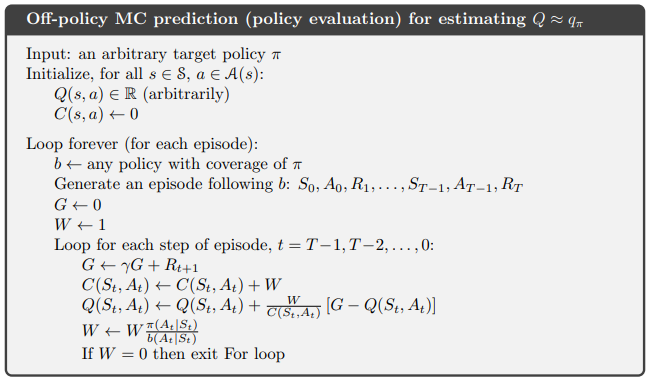

In [23]:
def get_off_policy_mc_prediction(env, num_episodes, discount_rate=1, is_exploring = False, is_control = False):

    n_actions = len(list(action_to_str.keys()))
    cum_weight = defaultdict(lambda: np.zeros(n_actions))
    q_table = defaultdict(lambda: np.ones(n_actions) * np.random.rand())

    # target policy follows random deterministic policy
    target_policy = {0: 1, 1: 1, 2: 1, 4: 0, 6: 0, 8: 1, 9: 1, 10: 0, 11: 3}


    for ep in tqdm(range(num_episodes)):

        episode, succeeded = gen_episode(env, 30, is_exploring)
        states, actions, rewards = zip(*episode)
        states_indexes = [env.get_index_state(state) for state in states]

        # number of states which is the same number of discount values, where
        # at each step we make exponent of gamma ** t as the discount factor
        len_states = len(states_indexes)

        weight = 1
        return_val = 0

        for i in range(len_states - 1, -1, -1):
            state = states_indexes[i]
            # Starting from the the last state, we calculate the discounted reward
            # from this state onward
            return_val = rewards[i] + discount_rate * return_val

            # updating the cummulative weight that is going to be used later in the incremental update of q_table
            cum_weight[state][actions[i]] = cum_weight[state][actions[i]] + weight

            # update the state_action (Q) table using importance sampling incremental update
            err = return_val - q_table[state][actions[i]]

            q_table[state][actions[i]] = q_table[state][actions[i]] + (weight / cum_weight[state][actions[i]]) *  err

            if actions[i] == target_policy[state]:
              target_probability = 1
            else:
              target_probability = 0

            behavior_prob = 1/n_actions

            weight = weight * target_probability/ behavior_prob

            # we break if the current action is not equal to the target policy action
            if weight == 0:
              break

    return q_table

In [25]:
action_to_str

{<Action.up: 0>: 'up',
 <Action.right: 1>: 'right',
 <Action.down: 2>: 'down',
 <Action.left: 3>: 'left'}

In [24]:
sorted(get_off_policy_mc_prediction(grid, 1000, discount_rate=1, is_exploring = False).items())

  0%|          | 0/1000 [00:00<?, ?it/s]

[(0, array([0.48731118, 0.74166667, 0.57966489, 0.58226121])),
 (1, array([0.76774942, 0.88019802, 0.76254545, 0.65502959])),
 (2, array([0.87297297, 1.        , 0.76834171, 0.75827815])),
 (4, array([0.67454545, 0.57676003, 0.48136882, 0.49829642])),
 (6, array([ 0.9       , -1.        ,  0.65294118,  0.76896552])),
 (8, array([ 0.55957973,  0.5758214 , -0.3027027 ,  0.49364114])),
 (9, array([ 0.57663198,  0.67900085,  0.57372401, -0.33058824])),
 (10, array([ 0.78615385, -0.1       ,  0.63913043,  0.51045296])),
 (11, array([-1.        , -0.14444444, -0.15714286, -0.1       ]))]

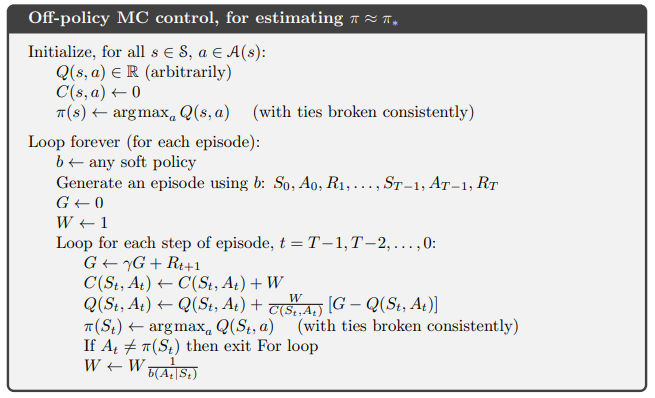

In [2]:
def get_off_policy_mc_control(env, num_episodes, discount_rate=1, is_exploring = False, is_control = False, verbose = False):

    n_actions = len(list(action_to_str.keys()))
    cum_weight = defaultdict(lambda: np.zeros(n_actions))
    q_table = defaultdict(lambda: np.ones(n_actions) * np.random.rand())

    # initialize q_table and target_policy
    target_policy = {}
    for state in [0, 1, 2, 4, 6, 8, 9, 10, 11]:
      target_policy[state] = np.argmax(q_table[state])

    if verbose:
      iterations = tqdm(range(num_episodes))
    else:
      iterations = range(num_episodes)


    for ep in iterations:
        episode, succeeded = gen_episode(env, 30, is_exploring)
        states, actions, rewards = zip(*episode)
        states_indexes = [env.get_index_state(state) for state in states]

        # number of states which is the same number of discount values, where
        # at each step we make exponent of gamma ** t as the discount factor
        len_states = len(states_indexes)

        weight = 1
        return_val = 0

        for i in range(len_states - 1, -1, -1):
            state = states_indexes[i]
            # Starting from the the last state, we calculate the discounted reward
            # from this state onward
            return_val = rewards[i] + discount_rate * return_val

            # updating the cummulative weight that is going to be used later in the incremental update of q_table
            cum_weight[state][actions[i]] = cum_weight[state][actions[i]] + weight

            # update the state_action (Q) table using importance sampling incremental update
            err = return_val - q_table[state][actions[i]]

            q_table[state][actions[i]] = q_table[state][actions[i]] + (weight / cum_weight[state][actions[i]]) *  err

            if actions[i] == target_policy[state]:
              target_probability = 1
            else:
              target_probability = 0

            behavior_prob = 1/n_actions

            target_policy[state] = np.argmax(q_table[state])

            # we break if the current action is not equal to the target policy action
            if actions[i] != target_policy[state]:
              break

            weight = weight / behavior_prob

    return q_table, target_policy

In [18]:
action_to_str

{<Action.up: 0>: 'up',
 <Action.right: 1>: 'right',
 <Action.down: 2>: 'down',
 <Action.left: 3>: 'left'}

In [20]:
def test_policy(episodes, trials, discount_rate = 1):
  optimal_n = 0
  non_opt = 0
  non_opt_list = []
  non_opt_state_visit = 0
  for trial in tqdm(range(trials)):
    q_table, target_policy = get_off_policy_mc_control(grid, episodes, discount_rate=discount_rate, is_exploring = False, verbose = False)

    optimal = True

    for x in list(optimal_policy.keys()):
      if x not in target_policy.keys():
        optimal = False
        non_opt_state_visit += 1
        break

    for state in target_policy:
      if target_policy[state] not in optimal_policy[state]:
        optimal = False

    if optimal:
      optimal_n += 1
    else:
      non_opt += 1
      non_opt_list.append(target_policy)
      print_policy(target_policy)
      print("-----------------------")


  return (optimal_n / (optimal_n + non_opt)) * 100, non_opt_state_visit /(optimal_n + non_opt) * 100 , non_opt_list

In [41]:
q_table, target_policy = get_off_policy_mc_control(grid, 1000, discount_rate=1, is_exploring = False)

print_policy(target_policy)

[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬅️']]


In [46]:
optimal_rate, non_opt_visit, non_optimal_list = test_policy(100, 100)
optimal_rate, non_opt_visit

  0%|          | 0/100 [00:00<?, ?it/s]

[['➡️' '➡️' '➡️' '🎁']
 ['⬇️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '➡️']]
-----------------------
[['⬆️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬆️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬅️' '🧱' '⬆️' '🔥']
 ['⬅️' '⬆️' '⬆️' '➡️']]
-----------------------
[['⬅️' '⬇️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '➡️']]
-----------------------
[['⬇️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬇️' '⬆️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '⬅️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬇️' '➡️' '➡️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬇️' '🔥']
 ['⬆️' '⬆️' '⬆️' '⬇️']]
-----------------------
[['⬇️' '➡️' '➡️' '🎁']
 ['➡️' '🧱' '⬅️' '🔥']
 ['➡️' '⬅️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬆️' '➡️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬅️' '🧱' '⬆️' '🔥']
 ['⬇️' '➡️' '⬆️' '➡️']]
-----------------------

(7.000000000000001, 0.0)

In [45]:
optimal_rate, non_opt_visit, non_optimal_list = test_policy(1000, 100)
optimal_rate, non_opt_visit

  0%|          | 0/100 [00:00<?, ?it/s]

[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬆️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬇️']]
-----------------------

(89.0, 0.0)

In [47]:
optimal_rate, non_opt_visit, non_optimal_list = test_policy(10000, 100)
optimal_rate, non_opt_visit

  0%|          | 0/100 [00:00<?, ?it/s]

(100.0, 0.0)

In [24]:
optimal_rate, non_opt_visit, non_optimal_list = test_policy(100, 100, discount_rate = 0.9)
optimal_rate, non_opt_visit

  0%|          | 0/100 [00:00<?, ?it/s]

[['➡️' '⬅️' '➡️' '🎁']
 ['➡️' '🧱' '⬇️' '🔥']
 ['⬇️' '➡️' '➡️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '➡️']]
-----------------------
[['⬅️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬅️' '⬇️' '⬇️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬇️' '⬇️' '➡️' '➡️']]
-----------------------
[['⬆️' '⬇️' '➡️' '🎁']
 ['➡️' '🧱' '⬇️' '🔥']
 ['➡️' '➡️' '⬆️' '➡️']]
-----------------------
[['⬆️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬇️' '🔥']
 ['➡️' '⬆️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['➡️' '🧱' '⬆️' '🔥']
 ['⬇️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '⬇️' '➡️' '🎁']
 ['⬅️' '🧱' '⬆️' '🔥']
 ['⬆️' '⬇️' '➡️' '⬇️']]
-----------------------
[['⬆️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬇️' '➡️' '⬆️' '⬅️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '⬆️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬅️' '⬆️' '➡️' '➡️']]
-----------------------

(1.0, 0.0)

In [25]:
optimal_rate, non_opt_visit, non_optimal_list = test_policy(1000, 100, discount_rate = 0.9)
optimal_rate, non_opt_visit

  0%|          | 0/100 [00:00<?, ?it/s]

[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬇️']]
-----------------------


(92.0, 0.0)

In [50]:
optimal_rate, non_opt_visit, non_optimal_list = test_policy(10000, 100, discount_rate = 0.9)
optimal_rate, non_opt_visit

  0%|          | 0/100 [00:00<?, ?it/s]

(100.0, 0.0)

In [ ]:
optimal_rate, non_optimal_list = test_policy(1000, 100, 0.9)
optimal_rate

  0%|          | 0/100 [00:00<?, ?it/s]

[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬇️' '🔥']
 ['⬆️' '⬅️' '⬅️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['➡️' '➡️' '⬆️' '➡️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '⬇️']]
-----------------------
[['➡️' '➡️' '➡️' '🎁']
 ['⬆️' '🧱' '⬆️' '🔥']
 ['⬆️' '➡️' '⬆️' '⬇️']]
-----------------------

85.0

In [ ]:
optimal_rate, non_optimal_list = test_policy(10000, 100, 0.9)
optimal_rate

  0%|          | 0/100 [00:00<?, ?it/s]

100.0